In [7]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers, models
from tensorflow.keras.datasets import mnist
import numpy as np
import pandas as pd


In [ ]:
# Load and preprocess MNIST data
trainPath = "D:\Work\python\dl_clg\datasets\dl1\mnist_train.csv"
testPath = "D:\Work\python\dl_clg\datasets\dl1\mnist_test.csv"

x_train = pd.read_csv(trainPath)
x_test = pd.read_csv(testPath)



In [10]:
x_train.head(2)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# x_train.drop_columns(['label'])
x_train = x_train.drop(columns=['label']).values
x_test = x_test.drop(columns=['label']).values

# (x_train, _), (x_test, _) = mnist.load_data()



In [33]:
# x_train.shape
# reshape data
x_train = np.reshape(x_train , (-1,28,28,1))
x_test = np.reshape(x_test , (-1,28,28,1))

In [38]:
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

In [35]:
# Define a sparsity constraint using KL divergence regularization
sparsity_weight = 1e-4  # Adjust based on the level of sparsity you want
rho = 0.05  # Desired sparsity level

def kl_divergence_regularizer(rho):
    def regularizer(x):
        rho_hat = tf.reduce_mean(tf.nn.sigmoid(x), axis=0)  # Average activation per neuron
        return sparsity_weight * tf.reduce_sum(
            rho * tf.math.log(rho / rho_hat) + (1 - rho) * tf.math.log((1 - rho) / (1 - rho_hat))
        )
    return regularizer



In [39]:
# Build the autoencoder model
latent_dim = 64  # Size of the encoded representation

# Encoder
input_img = layers.Input(shape=(28, 28, 1))
x = layers.Flatten()(input_img)
x = layers.Dense(128, activation="relu")(x)
encoded = layers.Dense(latent_dim, activation="sigmoid", 
                       activity_regularizer=kl_divergence_regularizer(rho))(x)

# Decoder
x = layers.Dense(128, activation="relu")(encoded)
x = layers.Dense(28 * 28, activation="sigmoid")(x)
decoded = layers.Reshape((28, 28, 1))(x)



In [40]:
# Autoencoder model
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

# Train the autoencoder
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test))


Epoch 1/50
235/235 [==============================] - 3s 8ms/step - loss: 0.2829 - val_loss: 0.2423
Epoch 2/50
235/235 [==============================] - 1s 6ms/step - loss: 0.2256 - val_loss: 0.2065
Epoch 3/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1880 - val_loss: 0.1723
Epoch 4/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1649 - val_loss: 0.1567
Epoch 5/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1522 - val_loss: 0.1454
Epoch 6/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1416 - val_loss: 0.1342
Epoch 7/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1317 - val_loss: 0.1268
Epoch 8/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1258 - val_loss: 0.1217
Epoch 9/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1200 - val_loss: 0.1156
Epoch 10/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1151 - val_loss: 0.1118

1/1 [==============================] - 0s 86ms/step


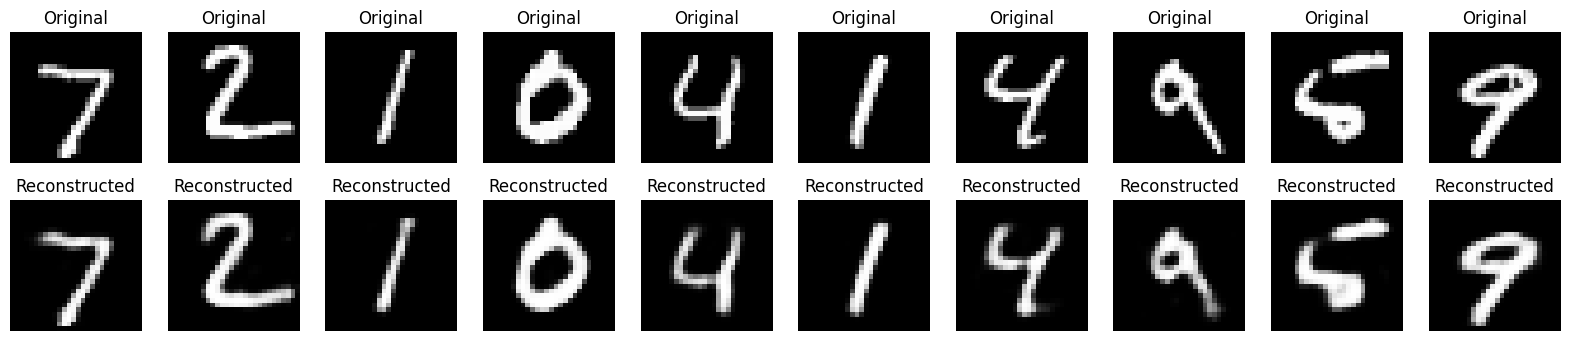

In [41]:
import matplotlib.pyplot as plt

# Generate reconstructed images
n = 10  # Number of images to display
original_images = x_test[:n]
reconstructed_images = autoencoder.predict(original_images)

# Plot the original and reconstructed images
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(original_images[i].reshape(28, 28), cmap="gray")
    plt.title("Original")
    plt.axis("off")
    
    # Display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].reshape(28, 28), cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")

plt.show()
